In [70]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from torch.utils.tensorboard import SummaryWriter
import ptflops

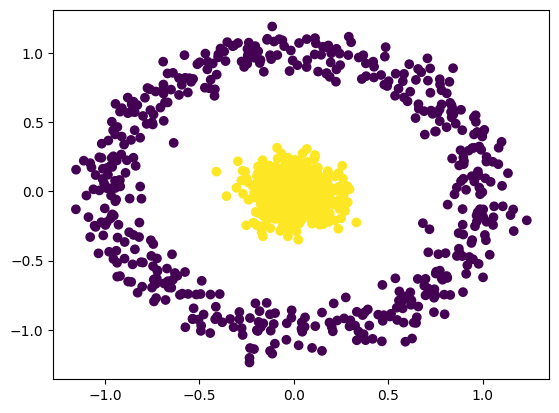

In [2]:
X, Y = make_circles(1000, factor=0.1, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [3]:
net = nn.Sequential(nn.Linear(2, 4), nn.ReLU(), nn.Linear(4, 2))

In [76]:
class MyNet(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear1 = nn.Linear(2, hidden_dim)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, 2)
        self.linear3 = nn.Sequential(nn.Linear(hidden_dim, 2))

    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)

        return x

In [77]:
net = MyNet(4)

In [10]:
def foo(layer, inp,):
    print(inp)


In [12]:
handle = net.linear1.register_forward_pre_hook(foo)

In [14]:
handle.remove()

In [53]:
class MyTensorDataset(torch.utils.data.Dataset):
    def __init__(self, *args):
        super().__init__()
        self.data = args

        base_tensor = self.data[0]

        for tensor in self.data:
            assert base_tensor.size(0) == tensor.size(0)

    def __len__(self, ):
        return self.data[0].size(0)
    
    def __getitem__(self, index):
        return [tensor[index] for tensor in self.data]


In [54]:
def my_collate_fn(*args):
    args = args[0]
    x = torch.cat([i[0].unsqueeze(0) for i in args], dim=0)
    y = torch.cat([i[1].unsqueeze(0) for i in args], dim=0)

    return {"x": x, "y": y}

In [55]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

X_train, X_test, Y_train, Y_test, = train_test_split(X, Y, test_size=0.3)
train_dataset = MyTensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
test_dataset = MyTensorDataset(torch.FloatTensor(X_test), torch.LongTensor(Y_test))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,) #collate_fn=my_collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,) #collate_fn=my_collate_fn)

In [78]:
for layer in net.children():
    print(layer)

Linear(in_features=2, out_features=4, bias=True)
ReLU()
Linear(in_features=4, out_features=2, bias=True)
Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)


In [79]:
for layer in net.named_children():
    print(layer)

('linear1', Linear(in_features=2, out_features=4, bias=True))
('act', ReLU())
('linear2', Linear(in_features=4, out_features=2, bias=True))
('linear3', Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
))


In [81]:
for layer in net.modules():
    print(layer)

MyNet(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act): ReLU()
  (linear2): Linear(in_features=4, out_features=2, bias=True)
  (linear3): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
)
Linear(in_features=2, out_features=4, bias=True)
ReLU()
Linear(in_features=4, out_features=2, bias=True)
Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)
Linear(in_features=4, out_features=2, bias=True)


In [80]:
for layer in net.named_modules():
    print(layer)

('', MyNet(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act): ReLU()
  (linear2): Linear(in_features=4, out_features=2, bias=True)
  (linear3): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
))
('linear1', Linear(in_features=2, out_features=4, bias=True))
('act', ReLU())
('linear2', Linear(in_features=4, out_features=2, bias=True))
('linear3', Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
))
('linear3.0', Linear(in_features=4, out_features=2, bias=True))


In [ ]:
ptflops.get_model_complexity_info(net, (1, 2), )

MyNet(
  32, 100.000% Params, 26.0 Mac, 86.667% MACs, 
  (linear1): Linear(12, 37.500% Params, 12.0 Mac, 40.000% MACs, in_features=2, out_features=4, bias=True)
  (act): ReLU(0, 0.000% Params, 4.0 Mac, 13.333% MACs, )
  (linear2): Linear(10, 31.250% Params, 10.0 Mac, 33.333% MACs, in_features=4, out_features=2, bias=True)
  (linear3): Linear(10, 31.250% Params, 0.0 Mac, 0.000% MACs, in_features=4, out_features=2, bias=True)
)


('30 Mac', '32')

In [ ]:
MAC ~ 1/2 FLOPS

In [ ]:
Multiply- accumulation 

In [ ]:
w * x + b

In [56]:
writer = SummaryWriter()

In [ ]:
#wandb.init()

In [59]:
loss_history_train = []
loss_history_test = []

n_epochs = 10


for i in range(n_epochs):
    for j, batch in enumerate(tqdm(train_dataloader)):
        x_batch, y_batch = batch
        optimizer.zero_grad()
       # y_batch = y_batch.cuda()
        y_pred = net(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        loss_history_train.append(loss.item())
        writer.add_scalar("Train loss", loss.item(), i * len(train_dataloader) + j)
        #wandb.log({"Train loss": loss.item()})

    for j, batch in enumerate(tqdm(test_dataloader)):
        x_batch, y_batch = batch
       # y_batch = y_batch.cuda()
        with torch.no_grad():
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch)
            
        loss_history_test.append(loss.item())
        writer.add_scalar("Val loss", loss.item(), i * len(train_dataloader) + j)

    writer.add_scalars("Mean Loss", {"Train loss": np.mean(loss_history_train[-len(train_dataloader):]), "Val loss": np.mean(loss_history_test[-len(train_dataloader):])}, i)
    torch.save(net.state_dict(), f'checkpoints/checkpoint_{i}.pth')
    
    clear_output(wait=True)
    figure = plt.figure()
    plt.plot(loss_history_train, label='train')
    plt.plot(loss_history_test, label='test')
    plt.legend()

    writer.add_figure("MPL Loss Plot", figure, i)
    plt.show()

100%|██████████| 38/38 [00:00<00:00, 2235.24it/s]


In [84]:
writer.close()

In [66]:
net.load_state_dict(torch.load('checkpoints/checkpoint_9.pth', map_location='cpu'), strict=False)

C:\Users\Azat\AppData\Local\Temp\ipykernel_4372\3172767762.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('checkpoints/checkpoint_9.pth',

_IncompatibleKeys(missing_keys=['linear3.weight', 'linear3.bias'], unexpected_keys=[])

In [ ]:
nn.Sequential(Resnet, nn.Linear(Resnet_dim, 10))

In [ ]:
for p in Resnet.parameters():
    p.requires_grad=False

In [74]:
test_preds = []

for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        y_pred = net(x_batch)
    test_preds = np.append(test_preds, y_pred.argmax(dim=-1).numpy())

100%|██████████| 38/38 [00:00<00:00, 863.68it/s]


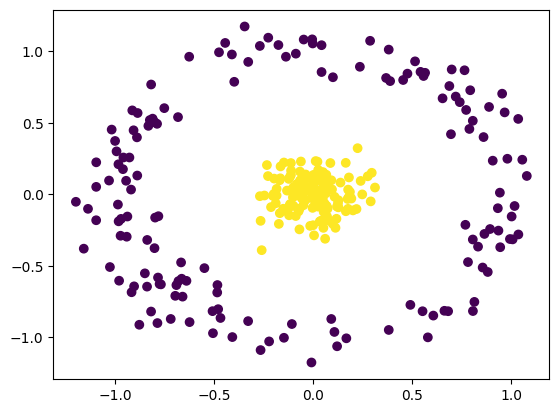

In [75]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_preds)

In [127]:
from functools import partial

In [128]:
net = nn.Sequential(nn.Linear(2, 4), nn.Sigmoid(), nn.Linear(4, 4), nn.Sigmoid(),  nn.Linear(4, 2))

In [129]:
grad_logs = {}

def log_grad(module, inp, out, layer_name):
    grad_logs[layer_name].append((out[0] ** 2).mean().item())

In [130]:
handles = []

In [131]:
for name, child in net.named_children():
    if isinstance(child, nn.Linear):
        grad_logs[name] = []
        handles.append(child.register_full_backward_hook(partial(log_grad, layer_name=name)))

In [132]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

X_train, X_test, Y_train, Y_test, = train_test_split(X, Y, test_size=0.3)
train_dataset = MyTensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
test_dataset = MyTensorDataset(torch.FloatTensor(X_test), torch.LongTensor(Y_test))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True,) #collate_fn=my_collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False,) #collate_fn=my_collate_fn)

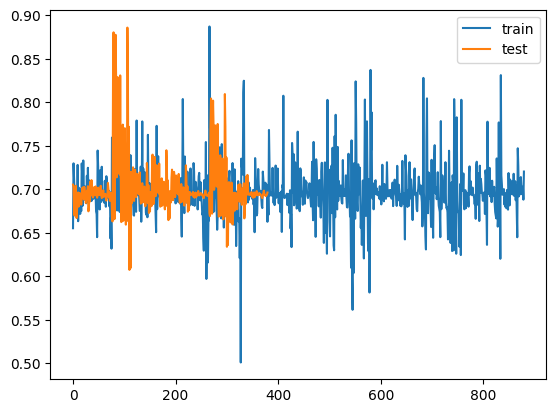

In [133]:
loss_history_train = []
loss_history_test = []

n_epochs = 10


for i in range(n_epochs):
    for j, batch in enumerate(tqdm(train_dataloader)):
        x_batch, y_batch = batch
        optimizer.zero_grad()
       # y_batch = y_batch.cuda()
        y_pred = net(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        loss_history_train.append(loss.item())
        #writer.add_scalar("Train loss", loss.item(), i * len(train_dataloader) + j)
        #wandb.log({"Train loss": loss.item()})

    for j, batch in enumerate(tqdm(test_dataloader)):
        x_batch, y_batch = batch
       # y_batch = y_batch.cuda()
        with torch.no_grad():
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch)
            
        loss_history_test.append(loss.item())
       # writer.add_scalar("Val loss", loss.item(), i * len(train_dataloader) + j)

    #writer.add_scalars("Mean Loss", {"Train loss": np.mean(loss_history_train[-len(train_dataloader):]), "Val loss": np.mean(loss_history_test[-len(train_dataloader):])}, i)
    #torch.save(net.state_dict(), f'checkpoints/checkpoint_{i}.pth')
    
    clear_output(wait=True)
    figure = plt.figure()
    plt.plot(loss_history_train, label='train')
    plt.plot(loss_history_test, label='test')
    plt.legend()

   # writer.add_figure("MPL Loss Plot", figure, i)
    plt.show()

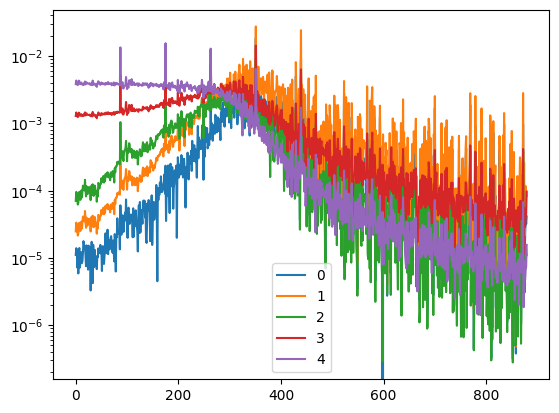

In [126]:
for key in grad_logs.keys():
    plt.plot(grad_logs[key], label=key)

plt.yscale('log')
plt.legend()
plt.show()

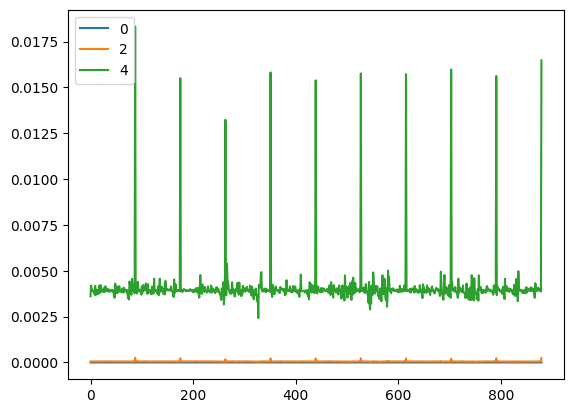

In [136]:
for key in grad_logs.keys():
    plt.plot(grad_logs[key], label=key)

plt.legend()
plt.show()

In [137]:
import mnist

X_train, Y_train, X_val, Y_val, X_test, Y_test  = mnist.load_dataset()

In [138]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

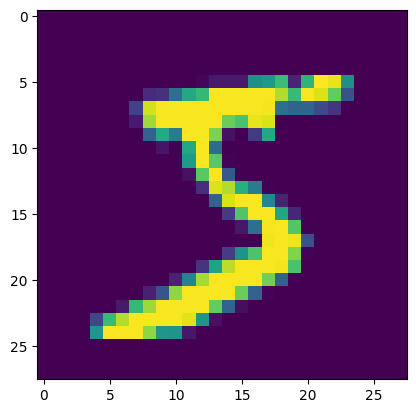

In [140]:
plt.imshow(X_train[0].reshape((28, 28)))

In [167]:
net = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax())

In [168]:
net

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
  (3): LogSoftmax(dim=None)
)

In [169]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
criterion = nn.NLLLoss()

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(Y_test))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

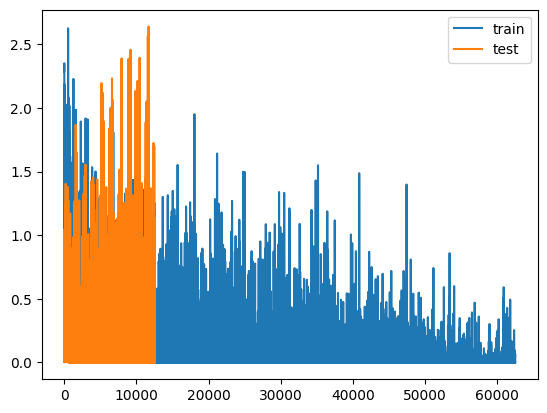

In [170]:
loss_history_train = []
loss_history_test = []

n_epochs = 10

for i in range(n_epochs):
    net.train()
    for x_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
       # y_batch = y_batch.cuda()
        y_pred = net(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()

        optimizer.step()
        loss_history_train.append(loss.item())

    net.eval()
    for x_batch, y_batch in tqdm(test_dataloader):
       # y_batch = y_batch.cuda()
        with torch.no_grad():
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch)
            
        loss_history_test.append(loss.item())


    clear_output(wait=True)
    plt.plot(loss_history_train, label='train')
    plt.plot(loss_history_test, label='test')
    plt.legend()
    plt.show()

In [ ]:
handle.remove()

In [171]:
acts = []

handle = net[1].register_forward_hook(lambda mod, inp, out: acts.append(out))

In [172]:
test_preds = []
y_batches = []

for x_batch, y_batch in tqdm(test_dataloader):
    net.eval()
    with torch.no_grad():
        y_pred = net(x_batch)
    test_preds = np.append(test_preds, y_pred.argmax(dim=-1).numpy())
    y_batches.append(y_batch.numpy())

100%|██████████| 1250/1250 [00:00<00:00, 2662.33it/s]


In [173]:
y_batches

[array([7, 2, 1, 0, 4, 1, 4, 9], dtype=int64),
 array([5, 9, 0, 6, 9, 0, 1, 5], dtype=int64),
 array([9, 7, 3, 4, 9, 6, 6, 5], dtype=int64),
 array([4, 0, 7, 4, 0, 1, 3, 1], dtype=int64),
 array([3, 4, 7, 2, 7, 1, 2, 1], dtype=int64),
 array([1, 7, 4, 2, 3, 5, 1, 2], dtype=int64),
 array([4, 4, 6, 3, 5, 5, 6, 0], dtype=int64),
 array([4, 1, 9, 5, 7, 8, 9, 3], dtype=int64),
 array([7, 4, 6, 4, 3, 0, 7, 0], dtype=int64),
 array([2, 9, 1, 7, 3, 2, 9, 7], dtype=int64),
 array([7, 6, 2, 7, 8, 4, 7, 3], dtype=int64),
 array([6, 1, 3, 6, 9, 3, 1, 4], dtype=int64),
 array([1, 7, 6, 9, 6, 0, 5, 4], dtype=int64),
 array([9, 9, 2, 1, 9, 4, 8, 7], dtype=int64),
 array([3, 9, 7, 4, 4, 4, 9, 2], dtype=int64),
 array([5, 4, 7, 6, 7, 9, 0, 5], dtype=int64),
 array([8, 5, 6, 6, 5, 7, 8, 1], dtype=int64),
 array([0, 1, 6, 4, 6, 7, 3, 1], dtype=int64),
 array([7, 1, 8, 2, 0, 2, 9, 9], dtype=int64),
 array([5, 5, 1, 5, 6, 0, 3, 4], dtype=int64),
 array([4, 6, 5, 4, 6, 5, 4, 5], dtype=int64),
 array([1, 4,

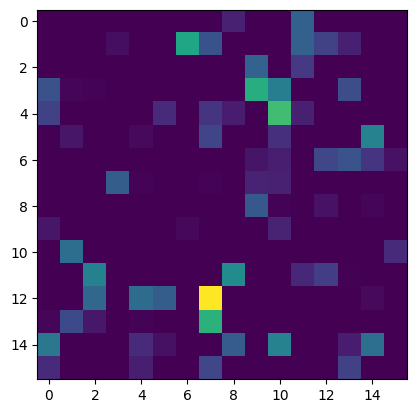

In [174]:
plt.imshow(acts[1][1].reshape((16, 16)))
plt.show()

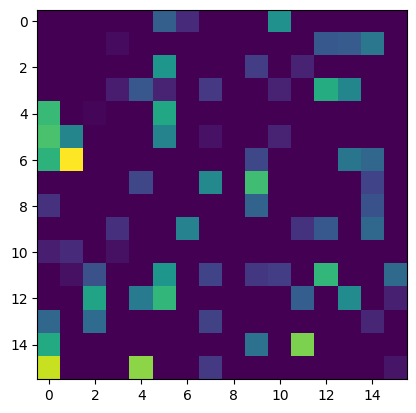

In [175]:
plt.imshow(acts[2][0].reshape((16, 16)))
plt.show()

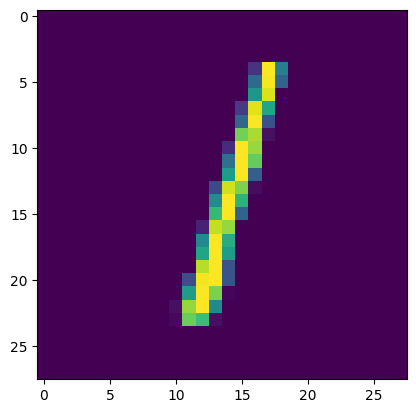

In [100]:
plt.imshow(test_dataset[2][0].reshape(28, 28))

In [101]:
test_preds[2]

1.0

In [102]:
(test_preds == Y_test).mean()

0.9829